## ECON 8185 - Homework Assignment 4

#### Xiang Liu
#### Email: liu01246@umn.edu
#### ID: 5596987
#### I gained a lot of help from Yutong Zhong and Yuta Maeda.

I use Colab to run this code. First, I just use the original "model.py", ""dp_algos.py", and "plot_code.py" directly. At the end of this notebook, I try to rewrite those files (not necessary).

In [1]:
from model import *
from dp_algos import *
from plot_code import *

import jax
import jax.numpy as jnp

In [2]:
# Use 64 bit floats with JAX in order to increase precision.

jax.config.update("jax_enable_x64", True)

In [3]:
def T(v, model, v_greedy=False):

## The Bellman operator or v-greedy function.

    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)


    r = jnp.reshape(r, (n_y, 1, n_y))           # r[y, a] --> r[y, z, a]
    β = jnp.reshape(z_vals, (1, n_z, 1))        # β[z] --> β[y, z, a]

    # Calculate continuation rewards at all combinations of (y, z, a, yp, zp)

    v = jnp.reshape(v, (1, 1, 1, n_y, n_z))     # v[yp, zp] --> v[y, z, a, yp, zp]
    R = jnp.reshape(R, (n_y, 1, n_y, n_y, 1))   # R[y, a, yp] --> R[y, z, a, yp, zp]
    Q = jnp.reshape(Q, (1, n_z, 1, 1, n_z))     # Q[z, zp] --> Q[y, z, a, yp, zp]

    # Sum over yp, zp
    Ev = jnp.sum(v * R * Q, axis = [3,4])       # Ev[y, z, a]

    new_v = r + β * Ev

    value = r + β * Ev

    # Mask the invalid indices (a >= K + 1 - y invalid)

    a_mask = y_vals[None, :] < K - y_vals[:, None] + 1
    a_mask = jnp.reshape(a_mask, (n_y, 1, n_y))

    value = jnp.where(a_mask, value, -np.inf)

    new_v = jnp.max(value, axis = 2)
    σ_star = jnp.argmax(value, axis = 2)

    if v_greedy:
      return σ_star
    else:
      return new_v


In [4]:
def T_σ(v, σ, model):

    "The policy operator."

    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)

    # expand the y and z grids, n = n_y x n_z
    y_grid = jnp.repeat(jnp.arange(n_y), n_z)
    z_grid = jnp.tile(jnp.arange(n_z), n_y)

    # Calculate continuation rewards at all combinations of (y, z, a, yp, zp)

    β = z_vals[z_grid]
    a = σ[y_grid, z_grid]
    v = jnp.reshape(v, (1, n_y, n_z)) # v[yp, zp] --> v[y\z, yp, zp]

    # Sum over yp, zp
    Ev = jnp.sum(v * R[y_grid,  a, :, None] * Q[z_grid, None, :], axis = [1,2])

    new_v = r[y_grid, a] +  β * Ev
    new_v = jnp.reshape(new_v, (n_y, n_z))
    return new_v


In [5]:
def get_value(σ, model):

    "Get the value v_σ of policy σ."

    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals), len(z_vals)
    n = n_z * n_y

    # Expand the y and z grids, n = n_y x n_z
    y_grid = jnp.repeat(jnp.arange(n_y), n_z)
    z_grid = jnp.tile(jnp.arange(n_z), n_y)
    a = σ[y_grid, z_grid]
    β = z_vals[z_grid]

    # Build L_σ and r_σ as multi-index arrays
    β = jnp.reshape(β, (n, 1, 1))
    L_σ = β * R[y_grid, a, :, None] * Q[z_grid, None, :]

    L_σ = jnp.reshape(L_σ, (n, n))
    r_σ = r[y_grid, a]
    I = jnp.eye(n)                       # An identity matrix
    v_σ = jnp.linalg.solve(I - L_σ, r_σ) # solve v_σ = r_σ(I - L_σ)^{-1}

    # Return as multi-index array
    return jnp.reshape(v_σ, (n_y, n_z))


In [6]:
## Custom solvers

def solve_model_jax(model, algorithm="OPI", **kwargs):
    """
    General purpose solver.

    algorithm : OPI, VFI or HPI

    """

    # Set up
    n_y, n_z = model.sizes
    v_init = jnp.zeros((n_y, n_z))

    # Solve
    print(f"Solving model using {algorithm}.")
    match algorithm:
        case "OPI":
            solver = optimistic_policy_iteration
            args = (v_init,
                lambda v, σ: T_σ(v, σ, model),
                lambda v: T(v, model, v_greedy = True))
        case "HPI":
            solver = howard_policy_iteration
            args = (v_init,
                lambda σ: get_value(σ, model),
                lambda v: T(v, model, v_greedy = True))
        case "VFI":
            solver = value_function_iteration
            args = (v_init,
                lambda v: T(v, model, v_greedy = False),
                lambda v: T(v, model, v_greedy = True))
        case _:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    v_star, σ_star = solver(*args, **kwargs, usejax = True)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [7]:
def test_timing_jax(model,
                      m_vals=range(1, 100, 20),
                      figname="jax_timing.pdf",
                      savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_jax(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_jax(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = jnp.max(jnp.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_jax(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = jnp.max(jnp.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time,
                vfi_time,
                opi_times,
                m_vals,
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

In [8]:
# Simulations and plots
T = jax.jit(T, static_argnums=(2, ))
T_σ = jax.jit(T_σ, static_argnums=None)
get_value = jax.jit(get_value, static_argnums=None)

model = create_sdd_inventory_model()

Building model with ρ(L) = 0.9751716609507874


In [9]:
# Solve by VFI

v_star, σ_star = solve_model_jax(model, algorithm="VFI")

Solving model using VFI.
Completed iteration 25 with error 0.561291818742589.
Completed iteration 50 with error 0.3776031152708832.
Completed iteration 75 with error 0.22781271574230288.
Completed iteration 100 with error 0.12966912474841052.
Completed iteration 125 with error 0.06841133244552822.
Completed iteration 150 with error 0.03108826968598777.
Completed iteration 175 with error 0.014717604780912552.
Completed iteration 200 with error 0.007728671529960707.
Completed iteration 225 with error 0.0041302272069572155.
Completed iteration 250 with error 0.002206459813073991.
Completed iteration 275 with error 0.0011779116780843424.
Completed iteration 300 with error 0.0006285733275817051.
Completed iteration 325 with error 0.0003353535262249352.
Completed iteration 350 with error 0.00017889424245964847.
Completed iteration 375 with error 9.542456400879473e-05.
Completed iteration 400 with error 5.089879924469187e-05.
Completed iteration 425 with error 2.7148494247342114e-05.
Complete

In [10]:

# Solve by HPI

v_star_hpi, σ_star_hpi = solve_model_jax(model, algorithm="HPI")

Solving model using HPI.
Concluded loop 1 with error 66.
Concluded loop 2 with error 60.
Concluded loop 3 with error 32.
Concluded loop 4 with error 32.
Concluded loop 5 with error 24.
Concluded loop 6 with error 24.
Concluded loop 7 with error 24.
Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:1.48
Solved model using HPI in 1.48458 seconds.


In [11]:
# Solve by OPI

v_star_opi, σ_star_opi = solve_model_jax(model, algorithm="OPI")

Solving model using OPI.
Completed iteration 10 with error 0.003989144284915369.
TOC: Elapsed: 0:00:1.70
Solved model using OPI in 1.70295 seconds.


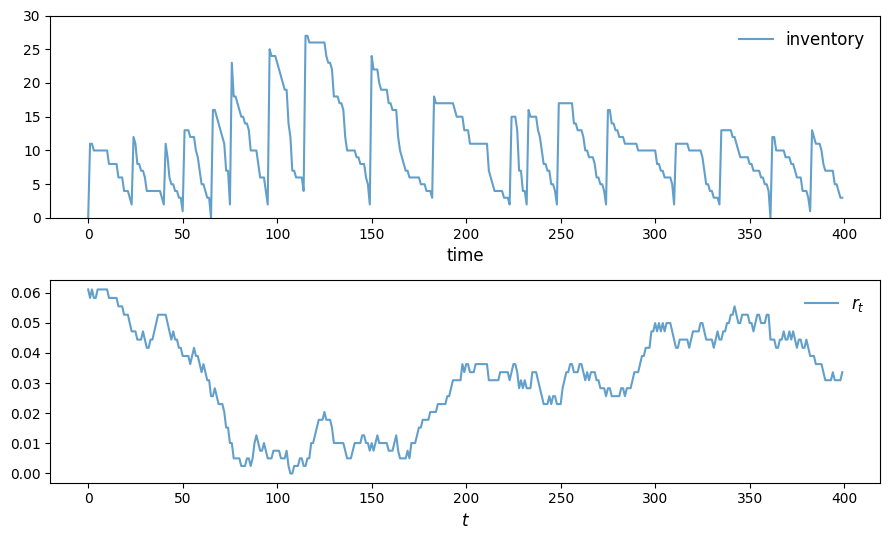

In [12]:
# Plot

plot_ts(model, σ_star_hpi, figname="jax_ts.pdf", savefig=False)

Solving model using HPI.
Concluded loop 1 with error 66.
Concluded loop 2 with error 60.
Concluded loop 3 with error 32.
Concluded loop 4 with error 32.
Concluded loop 5 with error 24.
Concluded loop 6 with error 24.
Concluded loop 7 with error 24.
Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:1.05
Solved model using HPI in 1.05450 seconds.
TOC: Elapsed: 0:00:1.05
Solving model using VFI.
Completed iteration 25 with error 0.561291818742589.
Completed iteration 50 with error 0.3776031152708832.
Completed iteration 75 with error 0.22781271574230288.
Completed iteration 100 with error 0.12966912474841052.
Completed iteration 125 with error 0.06841133244552822.
Completed iteration 150 with error 0.03108826968598777.
Completed iteration 175 with error 0.014717604780912552.
Completed iteration 200 with error 0.007728671529960707.
Completed iteration 225 with error 0.0041302272069572155.
Completed iteration 250 with error 0.002206459813073991.
Completed iteration 275 with error 0.00117791

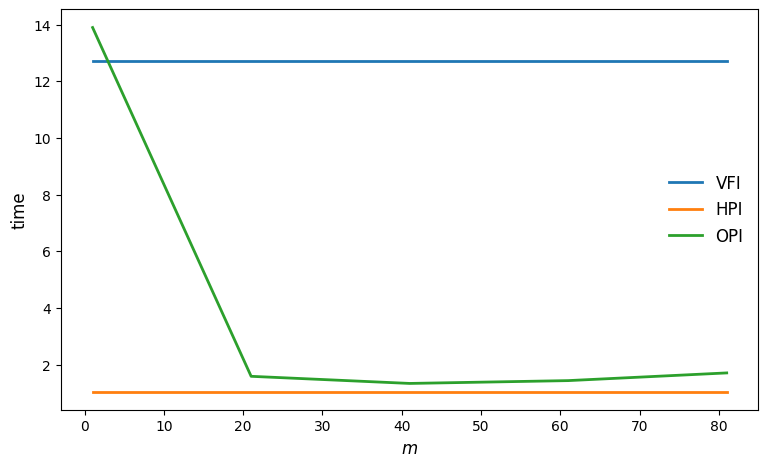

In [13]:
# Test timing

hpi_time, vfi_time, opi_times = test_timing_jax(model)

Model:

In [16]:
# def f(y, a, d):
#     # " Inventory update rule. "
#     return jnp.maximum(y - d, 0) + a

# # NamedTuple to hold model parameters
# Params = namedtuple(
#          "Params", ("K", "c", "κ", "p"))


# def build_R(params, y_vals, d_vals, ϕ_vals):
#     " Build the R array using loops. "
#     K, c, κ, p = params
#     n_y = K + 1
#     R = np.zeros((n_y, n_y, n_y))
#     for y in y_vals:
#         for yp in y_vals:
#             for a in range(n_y - y):
#                 hits = f(y, a, d_vals) == yp
#                 R[y, a, yp] = np.sum(hits * ϕ_vals)
#     return R

# def build_R_vectorized(params, y_vals, d_vals, ϕ_vals):
#     K, c, κ, p = params
#     n_y = K + 1
#     n_d = len(d_vals)
#     # Create R[y, a, yp, d] and then sum out last dimension
#     y  = np.reshape(y_vals, (n_y, 1, 1, 1))
#     a  = np.reshape(y_vals, (1, n_y, 1, 1))
#     yp = np.reshape(y_vals, (1, 1, n_y, 1))
#     d  = np.reshape(d_vals, (1, 1, 1, n_d))
#     ϕ  = np.reshape(ϕ_vals, (1, 1, 1, n_d))
#     feasible = a <= K - y
#     temp = (f(y, a, d_vals) == yp) * feasible
#     R = np.sum(temp * ϕ_vals, axis=3)
#     return R



# def build_r(params, y_vals, d_vals, ϕ_vals):
#     K, c, κ, p = params
#     n_y = K + 1
#     r = np.full((n_y, n_y), -np.inf)
#     for y in y_vals:
#         revenue = np.sum(np.minimum(y, d_vals) * ϕ_vals)
#         for a in range(n_y - y):
#             cost = c * a + κ * (a > 0)
#             r[y, a] = revenue - cost
#     return r


# def build_r_vectorized(params, y_vals, d_vals, ϕ_vals):
#     K, c, κ, p = params
#     n_y = K + 1
#     n_d = len(d_vals)
#     y = np.reshape(y_vals, (n_y, 1))
#     d = np.reshape(d_vals, (1, n_d))
#     ϕ = np.reshape(ϕ_vals, (1, n_d))
#     revenue = np.minimum(y, d) * ϕ
#     exp_revenue = np.sum(revenue, axis=1)
#     exp_revenue = np.reshape(exp_revenue, (n_y, 1))
#     a = np.reshape(y_vals, (1, n_y))
#     cost = c * a + κ * (a > 0)
#     exp_profit = exp_revenue - cost
#     feasible = a <= K - y
#     r = np.where(feasible, exp_profit, -np.inf)
#     return r


# # NamedTuple to hold arrays used to solve model
# Arrays = namedtuple("Arrays", ("r", "R", "y_vals", "z_vals", "d_vals", "ϕ_vals","Q"))

# # NamedTuple to store parameters, array sizes, and arrays
# Model = namedtuple("Model", ("params", "sizes", "arrays"))

# def create_sdd_inventory_model(ρ=0.98,        # Z persistence
#                                ν=0.002,       # Z volatility
#                                n_z=25,        # size of Z grid
#                                b=0.97,        # Z mean
#                                K=100,         # max inventory
#                                d_max=100,     # max value of d
#                                c=0.2,         # unit cost
#                                κ=0.8,         # fixed cost
#                                p=0.6):        # demand parameter

#     n_y = K + 1               # size of state space
#     y_vals = np.arange(n_y)   # inventory levels 0,...,K

#     # Construct r and R arrays
#     def ϕ(d):
#         return (1 - p)**d * p

#     d_vals = np.arange(d_max)
#     ϕ_vals = ϕ(d_vals)

#     # Build the exogenous discount process
#     mc = qe.tauchen(n_z, ρ, ν)
#     z_vals, Q = mc.state_values + b, mc.P
#     ρL = np.max(np.abs(np.linalg.eigvals(z_vals * Q)))
#     if ρL >= 1:
#         raise NotImplementedError("Error: ρ(L) ≥ 1.")
#     else:
#         print(f"Building model with ρ(L) = {ρL}")

#     # Build namedtuples and return them
#     params = Params(K=K, c=c, κ=κ, p=p)
#     r = build_r_vectorized(params, y_vals, d_vals, ϕ_vals)
#     R = build_R_vectorized(params, y_vals, d_vals, ϕ_vals)

#     arrays = Arrays(r=r, R=R, y_vals=y_vals, z_vals=z_vals, d_vals = d_vals, ϕ_vals = ϕ_vals, Q=Q)
#     sizes = n_y, n_z
#     return Model(params=params, sizes=sizes, arrays=arrays)



dp_algos:

In [17]:
# def value_function_iteration(v_init,
#                              T,
#                              get_greedy,
#                              tolerance=1e-6,        # Error tolerance 1e-6
#                              max_iter=10_000,       # Max iteration bound
#                              print_step=25,         # Print at multiples
#                              verbose=True,
#                              usejax=True):
#     """
#         Compute v_star via VFI and then compute greedy.
#     """
#     array_lib = jnp if usejax else np

#     v = v_init
#     error = tolerance + 1
#     k = 1
#     while error > tolerance and k <= max_iter:
#         v_new = T(v)
#         error = array_lib.max(array_lib.abs(v_new - v))
#         if verbose and (k % print_step) == 0:
#             print(f"Completed iteration {k} with error {error}.")
#         v = v_new
#         k += 1
#     if error > tolerance:
#         print(f"Warning: Iteration hit upper bound {max_iter}.")
#     elif verbose:
#         print(f"Terminated successfully in {k} iterations.")
#     v_star = v
#     σ_star = get_greedy(v_star)
#     return v_star, σ_star


# def optimistic_policy_iteration(v_init,
#                                 T_σ,
#                                 get_greedy,
#                                 tolerance=1e-6,
#                                 max_iter=1_000,
#                                 print_step=10,
#                                 m=60,
#                                 usejax=True):
#     "Optimistic policy iteration routine."

#     array_lib = jnp if usejax else np
#     v = v_init
#     error = tolerance + 1
#     k = 1
#     while error > tolerance and k < max_iter:
#         last_v = v
#         σ = get_greedy(v)
#         for i in range(m):
#             v = T_σ(v, σ)
#         error = array_lib.max(array_lib.abs(v - last_v))
#         if k % print_step == 0:
#             print(f"Completed iteration {k} with error {error}.")
#         k += 1
#     return v, get_greedy(v)


# def howard_policy_iteration(v_init,
#                             get_value,
#                             get_greedy,
#                             tolerance=1e-6,
#                             max_iter=100,
#                             usejax=True):
#     "Howard policy iteration routine."
#     array_lib = jnp if usejax else np

#     σ = get_greedy(v_init)
#     error = tolerance + 1
#     k = 0
#     while error > tolerance and k < max_iter:
#         v_σ = get_value(σ)
#         σ_new = get_greedy(v_σ)
#         error = array_lib.max(array_lib.abs(σ_new - σ))
#         σ = σ_new
#         k = k + 1
#         print(f"Concluded loop {k} with error {error}.")
#     return v_σ, σ
